# Prédiction d'Investissement - Prévision Récursive

Ce notebook regroupe toutes les cellules nécessaires pour exécuter les prévisions récursives avec Chronos-2 et Moirai-2.


## 1. Configuration et imports

**Note**: Nous ajoutons le répertoire racine du projet au chemin Python pour importer nos modules personnalisés.


In [1]:
# Ajouter le répertoire racine du projet au chemin Python
import sys
from pathlib import Path

# Remonter deux niveaux pour atteindre la racine du projet (notebooks/archive -> notebooks -> racine)
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Imports standards
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Imports depuis nos scripts utilitaires
from ecb_forecast.compare import (
    Chronos2Runner,
    Moirai2Runner,
    merge_results,
    resolve_device,
    parse_torch_dtype
)
from ecb_forecast.datasets import (
    load_quarterly_dataset,
    compute_country_stats,
    prepare_country_context,
    prepare_moirai_inputs,
)

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports réussis!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {resolve_device('auto')}")


✅ Imports réussis!
PyTorch version: 2.4.1
Device disponible: mps


## 2. Chargement des données


In [ ]:
# Chemins des données (relatifs à la racine du projet)
DATA_DIR = project_root / "data" / "processed"
COMBINED_FILE = DATA_DIR / "investment_quarterly.csv"

# Colonnes dans les données
ID_COLUMN = "country"
TIMESTAMP_COLUMN = "timestamp"
TARGET_COLUMN = "investment"

# Chargement du fichier combiné
df_full, dataset_summary = load_quarterly_dataset(
    COMBINED_FILE,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
)

print(f"📊 Données chargées: {dataset_summary.num_rows} observations")
print(f"Pays disponibles: {dataset_summary.series_ids}")
print(
    f"Période: {dataset_summary.start.date()} → {dataset_summary.end.date()}"
)
print(f"\nAperçu des données:")
df_full.head()


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/investment_quarterly.csv'

In [ ]:
# Afficher quelques statistiques par pays
print("📈 Statistiques par pays:\n")
country_stats = compute_country_stats(
    df_full,
    id_column=ID_COLUMN,
    target_column=TARGET_COLUMN,
)
for stat in country_stats:
    print(
        f"{stat.series_id}: {stat.observations} observations | Moyenne: {stat.mean:.0f} | "
        f"Std: {stat.std:.0f} | Coverage: {stat.coverage:.1%}"
    )


📈 Statistiques par pays:

DE: 124 observations | Moyenne: 48984 | Std: 9133 | Coverage: 98.4%
ES: 124 observations | Moyenne: 15987 | Std: 2956 | Coverage: 99.2%
FR: 124 observations | Moyenne: 27024 | Std: 3993 | Coverage: 99.2%
IT: 124 observations | Moyenne: 30747 | Std: 3697 | Coverage: 95.2%


## 3. Configuration des modèles


In [ ]:
# ========== PARAMÈTRES À AJUSTER ==========

# Pays à prédire (choix: 'DE', 'ES', 'FR', 'IT')
TARGET_COUNTRY = "DE"

# Date de fin des données d'entraînement (début de la période de prévision)
CUTOFF_DATE = "2020-12-31"

# Horizon de prédiction (nombre de trimestres)
PREDICTION_LENGTH = 17

# Niveaux de quantiles pour les intervalles de confiance
QUANTILE_LEVELS = [0.1, 0.5, 0.9]

# Modèles à utiliser
CHRONOS_MODEL = "amazon/chronos-2"
MOIRAI_MODEL = "Salesforce/moirai-2.0-R-small"

# Paramètres de génération pour Moirai
MOIRAI_SAMPLES = 16
TEMPERATURE = 0.8
TOP_P = 0.9
TOP_K = 50

# Device et dtype
DEVICE = "auto"  # 'auto', 'cpu', 'cuda', or 'mps'
CHRONOS_DTYPE = "auto"  # 'auto', 'float32', 'float16', or 'bfloat16'
MOIRAI_DTYPE = "bfloat16"

print(f"🎯 Configuration:")
print(f"  Pays cible: {TARGET_COUNTRY}")
print(f"  Date de coupure: {CUTOFF_DATE}")
print(f"  Horizon: {PREDICTION_LENGTH} trimestres")
print(f"  Quantiles: {QUANTILE_LEVELS}")
print(f"  Device: {resolve_device(DEVICE)}")


🎯 Configuration:
  Pays cible: DE
  Date de coupure: 2020-12-31
  Horizon: 17 trimestres
  Quantiles: [0.1, 0.5, 0.9]
  Device: mps


## 4. Initialisation des modèles


In [ ]:
print("🔄 Chargement du modèle Chronos-2...")

chronos_device = resolve_device(DEVICE)
chronos_dtype = parse_torch_dtype(CHRONOS_DTYPE)

chronos_runner = Chronos2Runner(
    model_name=CHRONOS_MODEL,
    device_map=chronos_device,
    dtype=chronos_dtype
)

print("✅ Modèle Chronos-2 chargé!")
print(f"   Device: {chronos_device}")
print(f"   Dtype: {chronos_dtype}")


🔄 Chargement du modèle Chronos-2...


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


✅ Modèle Chronos-2 chargé!
   Device: mps
   Dtype: auto


In [ ]:
print("🔄 Chargement du modèle Moirai-2...")

moirai_device = resolve_device(DEVICE)
if moirai_device == "mps":
    print("⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)")
    moirai_device = "cpu"

moirai_dtype = parse_torch_dtype(MOIRAI_DTYPE)

moirai_runner = Moirai2Runner(
    model_name=MOIRAI_MODEL,
    device_map=moirai_device,
    dtype=moirai_dtype
)

print("✅ Modèle Moirai-2 chargé!")
print(f"   Device: {moirai_device}")
print(f"   Dtype: {moirai_dtype}")


🔄 Chargement du modèle Moirai-2...
⚠️  MPS détecté - utilisation de CPU pour Moirai-2 (meilleure compatibilité)
✅ Modèle Moirai-2 chargé!
   Device: cpu
   Dtype: torch.bfloat16


---

## 🔄 RECURSIVE FORECASTING APPROACH

This section implements a **recursive forecasting** methodology where:
- For each quarter, we forecast the next 4 quarters ahead
- Each forecast uses all historical data available up to that point
- This creates a rolling forecast window of 4 quarters


In [ ]:
## Configuration pour la prévision récursive

# Paramètres
RECURSIVE_HORIZON = 4  # Nombre de trimestres à prévoir à chaque itération
RECURSIVE_COUNTRY = "DE"  # Pays à analyser
RECURSIVE_START_DATE = "2020-10-01"  # Date de début des prévisions (premier point de départ)
RECURSIVE_END_DATE = "2025-01-01"  # Date de fin des prévisions

print(f"🎯 Configuration de la prévision récursive:")
print(f"  Pays: {RECURSIVE_COUNTRY}")
print(f"  Horizon par itération: {RECURSIVE_HORIZON} trimestres")
print(f"  Période de prévision: {RECURSIVE_START_DATE} → {RECURSIVE_END_DATE}")
print(f"  Quantiles: {QUANTILE_LEVELS}")


🎯 Configuration de la prévision récursive:
  Pays: DE
  Horizon par itération: 4 trimestres
  Période de prévision: 2020-10-01 → 2025-01-01
  Quantiles: [0.1, 0.5, 0.9]


In [ ]:
def recursive_forecast_chronos(
    full_df,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment"
):
    """
    Perform recursive forecasting with Chronos-2.
    
    For each quarter from start_date to end_date:
    - Use all historical data up to that quarter
    - Forecast the next 'horizon' quarters
    - Store the forecast
    
    Returns a DataFrame with all forecasts and their metadata.
    """
    results = []
    
    # Convert dates
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    # Filter for the country
    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    
    # Get all unique timestamps
    all_timestamps = sorted(country_df[timestamp_column].unique())
    
    # Find forecast origin points (quarters where we start forecasting from)
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]
    
    print(f"🔄 Performing recursive forecasting for {country}")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Horizon per origin: {horizon} quarters")
    
    for idx, origin_date in enumerate(forecast_origins):
        # Get all data up to (and including) the origin date
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        
        if len(context_data) < 4:  # Need at least some history
            continue
        
        # Prepare context
        try:
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=country,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Make prediction with Chronos
            chronos_result = chronos_runner.run(
                context_df=forecast_context.dataframe,
                prediction_length=horizon,
                quantile_levels=quantile_levels,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column
            )
            
            # Store results with metadata
            forecast_df = chronos_result.df.copy()
            forecast_df['origin_date'] = origin_date
            forecast_df['horizon_step'] = range(1, horizon + 1)
            forecast_df['model'] = 'Chronos-2'
            
            results.append(forecast_df)
            
            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
                
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue
    
    if not results:
        raise ValueError("No forecasts were generated")
    
    # Combine all results
    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    
    return all_forecasts


def recursive_forecast_moirai(
    full_df,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment"
):
    """
    Perform recursive forecasting with Moirai-2.
    
    For each quarter from start_date to end_date:
    - Use all historical data up to that quarter
    - Forecast the next 'horizon' quarters
    - Store the forecast
    
    Returns a DataFrame with all forecasts and their metadata.
    """
    results = []
    
    # Convert dates
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    # Filter for the country
    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    
    # Get all unique timestamps
    all_timestamps = sorted(country_df[timestamp_column].unique())
    
    # Find forecast origin points
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]
    
    print(f"🔄 Performing recursive forecasting for {country} with Moirai-2")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Horizon per origin: {horizon} quarters")
    
    for idx, origin_date in enumerate(forecast_origins):
        # Get all data up to (and including) the origin date
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        
        if len(context_data) < 4:
            continue
        
        try:
            # Prepare context
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=country,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Prepare Moirai inputs
            context_values, start_timestamp, freq = prepare_moirai_inputs(
                forecast_context.dataframe,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            
            # Make prediction with Moirai
            moirai_result = moirai_runner.run(
                values=context_values,
                prediction_length=horizon,
                quantile_levels=quantile_levels,
                forecast_index=forecast_context.forecast_index,
                start_timestamp=start_timestamp,
                freq=freq
            )
            
            # Store results with metadata
            forecast_df = moirai_result.df.copy()
            forecast_df['origin_date'] = origin_date
            forecast_df['horizon_step'] = range(1, horizon + 1)
            forecast_df['model'] = 'Moirai-2'
            
            results.append(forecast_df)
            
            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
                
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue
    
    if not results:
        raise ValueError("No forecasts were generated")
    
    # Combine all results
    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    
    return all_forecasts

print("✅ Recursive forecasting functions defined")


✅ Recursive forecasting functions defined


In [ ]:
## Exécution de la prévision récursive avec Chronos-2

recursive_chronos_forecasts = recursive_forecast_chronos(
    full_df=df_full,
    country=RECURSIVE_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"\n📊 Aperçu des prévisions récursives Chronos-2:")
print(f"  Total de prévisions: {len(recursive_chronos_forecasts)}")
print(f"  Colonnes: {list(recursive_chronos_forecasts.columns)}")
print(f"\nPremières lignes:")
recursive_chronos_forecasts.head(12)


🔄 Performing recursive forecasting for DE
  Number of forecast origins: 18
  Horizon per origin: 4 quarters
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...
  Completed 15/18 forecast origins...
✅ Completed 18 recursive forecasts

📊 Aperçu des prévisions récursives Chronos-2:
  Total de prévisions: 72
  Colonnes: ['timestamp', 'chronos_p10', 'chronos_p50', 'chronos_p90', 'origin_date', 'horizon_step', 'model']

Premières lignes:


,timestamp,chronos_p10,chronos_p50,chronos_p90,origin_date,horizon_step,model
0,2021-01-01,55514.625000,58550.984375,61064.148438,2020-10-01,1,Chronos-2
1,2021-04-01,55361.632812,59444.921875,62682.234375,2020-10-01,2,Chronos-2
2,2021-07-01,55522.453125,60117.648438,64048.652344,2020-10-01,3,Chronos-2
3,2021-10-01,55052.000000,60492.617188,65028.035156,2020-10-01,4,Chronos-2
4,2021-04-01,54872.738281,57893.164062,60243.140625,2021-01-01,1,Chronos-2
5,2021-07-01,53782.917969,58405.285156,61923.125000,2021-01-01,2,Chronos-2
6,2021-10-01,53017.929688,58780.742188,63389.031250,2021-01-01,3,Chronos-2
7,2022-01-01,52265.843750,59083.386719,64703.296875,2021-01-01,4,Chronos-2
8,2021-07-01,56629.007812,59052.148438,60799.355469,2021-04-01,1,Chronos-2
9,2021-10-01,55934.285156,59387.980469,61942.132812,2021-04-01,2,Chronos-2


In [ ]:
## Exécution de la prévision récursive avec Moirai-2

recursive_moirai_forecasts = recursive_forecast_moirai(
    full_df=df_full,
    country=RECURSIVE_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"\n📊 Aperçu des prévisions récursives Moirai-2:")
print(f"  Total de prévisions: {len(recursive_moirai_forecasts)}")
print(f"  Colonnes: {list(recursive_moirai_forecasts.columns)}")
print(f"\nPremières lignes:")
recursive_moirai_forecasts.head(12)


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data;

🔄 Performing recursive forecasting for DE with Moirai-2
  Number of forecast origins: 18
  Horizon per origin: 4 quarters
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...
  Completed 15/18 forecast origins...
✅ Completed 18 recursive forecasts

📊 Aperçu des prévisions récursives Moirai-2:
  Total de prévisions: 72
  Colonnes: ['timestamp', 'moirai_p10', 'moirai_p50', 'moirai_p90', 'moirai_mean', 'origin_date', 'horizon_step', 'model']

Premières lignes:


,timestamp,moirai_p10,moirai_p50,moirai_p90,moirai_mean,origin_date,horizon_step,model
0,2021-01-01,53215.886719,57534.367188,61504.871094,57534.367188,2020-10-01,1,Moirai-2
1,2021-04-01,51428.304688,57400.113281,62532.062500,57400.113281,2020-10-01,2,Moirai-2
2,2021-07-01,50014.484375,57129.488281,62919.664062,57129.488281,2020-10-01,3,Moirai-2
3,2021-10-01,49307.007812,57231.507812,63496.878906,57231.507812,2020-10-01,4,Moirai-2
4,2021-04-01,53338.000000,57168.593750,60769.457031,57168.593750,2021-01-01,1,Moirai-2
5,2021-07-01,51737.867188,57048.890625,61927.937500,57048.890625,2021-01-01,2,Moirai-2
6,2021-10-01,50342.968750,56771.617188,62447.214844,56771.617188,2021-01-01,3,Moirai-2
7,2022-01-01,49598.648438,56858.730469,63030.058594,56858.730469,2021-01-01,4,Moirai-2
8,2021-07-01,55351.078125,58608.015625,61507.480469,58608.015625,2021-04-01,1,Moirai-2
9,2021-10-01,54002.007812,58489.281250,62540.812500,58489.281250,2021-04-01,2,Moirai-2


In [ ]:
## Ajout des valeurs réelles (Ground Truth) aux prévisions récursives

def add_ground_truth_to_recursive(forecasts_df, actual_df, country, 
                                   timestamp_col='timestamp', 
                                   target_col='investment',
                                   id_col='country'):
    """Add actual values to the recursive forecast dataframe."""
    # Filter actual data for the country
    actual_country = actual_df[actual_df[id_col] == country].copy()
    actual_dict = dict(zip(actual_country[timestamp_col], actual_country[target_col]))
    
    # Add actual values based on the timestamp (not origin_date)
    forecasts_df['actual'] = forecasts_df[timestamp_col].map(actual_dict)
    
    return forecasts_df

# Add ground truth to both models' forecasts
recursive_chronos_forecasts = add_ground_truth_to_recursive(
    recursive_chronos_forecasts, 
    df_full, 
    RECURSIVE_COUNTRY,
    TIMESTAMP_COLUMN,
    TARGET_COLUMN,
    ID_COLUMN
)

recursive_moirai_forecasts = add_ground_truth_to_recursive(
    recursive_moirai_forecasts, 
    df_full, 
    RECURSIVE_COUNTRY,
    TIMESTAMP_COLUMN,
    TARGET_COLUMN,
    ID_COLUMN
)

print("✅ Ground truth values added to recursive forecasts")
print(f"\nChronos-2: {recursive_chronos_forecasts['actual'].notna().sum()} forecasts with actual values")
print(f"Moirai-2: {recursive_moirai_forecasts['actual'].notna().sum()} forecasts with actual values")


✅ Ground truth values added to recursive forecasts

Chronos-2: 66 forecasts with actual values
Moirai-2: 66 forecasts with actual values


In [ ]:
## Calcul des métriques de performance par horizon

def calculate_recursive_metrics(forecasts_df, model_name='Model'):
    """Calculate forecast accuracy metrics by horizon step."""
    
    # Get the median prediction column name
    median_col = [col for col in forecasts_df.columns if 'p50' in col.lower()][0]
    
    # Filter rows with actual values
    with_actual = forecasts_df[forecasts_df['actual'].notna()].copy()
    
    if len(with_actual) == 0:
        print(f"⚠️ No actual values available for {model_name}")
        return None
    
    # Calculate errors
    with_actual['error'] = with_actual[median_col] - with_actual['actual']
    with_actual['abs_error'] = np.abs(with_actual['error'])
    with_actual['squared_error'] = with_actual['error'] ** 2
    with_actual['pct_error'] = np.abs(with_actual['error'] / with_actual['actual']) * 100
    
    # Overall metrics
    overall_metrics = {
        'MAE': with_actual['abs_error'].mean(),
        'RMSE': np.sqrt(with_actual['squared_error'].mean()),
        'MAPE': with_actual['pct_error'].mean(),
        'Mean Error': with_actual['error'].mean(),
        'Std Error': with_actual['error'].std(),
        'N': len(with_actual)
    }
    
    # Metrics by horizon step
    horizon_metrics = []
    for horizon in sorted(with_actual['horizon_step'].unique()):
        horizon_data = with_actual[with_actual['horizon_step'] == horizon]
        horizon_metrics.append({
            'Horizon': f'{horizon}Q ahead',
            'N': len(horizon_data),
            'MAE': horizon_data['abs_error'].mean(),
            'RMSE': np.sqrt(horizon_data['squared_error'].mean()),
            'MAPE': horizon_data['pct_error'].mean(),
            'Mean Error': horizon_data['error'].mean(),
        })
    
    horizon_df = pd.DataFrame(horizon_metrics)
    
    return overall_metrics, horizon_df, with_actual

# Calculate metrics for both models
print("=" * 80)
print("📊 MÉTRIQUES DE PERFORMANCE - PRÉVISIONS RÉCURSIVES")
print("=" * 80)

# Chronos-2
chronos_overall, chronos_by_horizon, chronos_with_errors = calculate_recursive_metrics(
    recursive_chronos_forecasts, 'Chronos-2'
)

if chronos_overall:
    print(f"\n🔵 Chronos-2 - Métriques globales:")
    for metric, value in chronos_overall.items():
        if metric == 'N':
            print(f"  {metric}: {int(value)}")
        else:
            print(f"  {metric}: {value:.2f}")
    
    print(f"\n  Métriques par horizon:")
    print(chronos_by_horizon.to_string(index=False))

# Moirai-2
moirai_overall, moirai_by_horizon, moirai_with_errors = calculate_recursive_metrics(
    recursive_moirai_forecasts, 'Moirai-2'
)

if moirai_overall:
    print(f"\n🔴 Moirai-2 - Métriques globales:")
    for metric, value in moirai_overall.items():
        if metric == 'N':
            print(f"  {metric}: {int(value)}")
        else:
            print(f"  {metric}: {value:.2f}")
    
    print(f"\n  Métriques par horizon:")
    print(moirai_by_horizon.to_string(index=False))

# Comparison
if chronos_overall and moirai_overall:
    print(f"\n📊 Comparaison:")
    print(f"  MAE: Chronos-2 {chronos_overall['MAE']:.2f} vs Moirai-2 {moirai_overall['MAE']:.2f}")
    print(f"  RMSE: Chronos-2 {chronos_overall['RMSE']:.2f} vs Moirai-2 {moirai_overall['RMSE']:.2f}")
    print(f"  MAPE: Chronos-2 {chronos_overall['MAPE']:.2f}% vs Moirai-2 {moirai_overall['MAPE']:.2f}%")
    
    if chronos_overall['MAE'] < moirai_overall['MAE']:
        print(f"\n  ✅ Chronos-2 est plus précis (MAE inférieure)")
    else:
        print(f"\n  ✅ Moirai-2 est plus précis (MAE inférieure)")

print("\n" + "=" * 80)


📊 MÉTRIQUES DE PERFORMANCE - PRÉVISIONS RÉCURSIVES

🔵 Chronos-2 - Métriques globales:
  MAE: 2349.07
  RMSE: 2884.66
  MAPE: 4.04
  Mean Error: 1444.44
  Std Error: 2516.10
  N: 66

  Métriques par horizon:
 Horizon  N         MAE        RMSE     MAPE  Mean Error
1Q ahead 18 1249.722995 1472.386649 2.138558  563.326293
2Q ahead 17 1989.898869 2245.356952 3.409787 1156.310230
3Q ahead 16 2910.153359 3279.652261 5.003006 1833.227344
4Q ahead 15 3476.853740 4101.816574 5.997509 2413.612719

🔴 Moirai-2 - Métriques globales:
  MAE: 1393.21
  RMSE: 1775.57
  MAPE: 2.36
  Mean Error: -129.42
  Std Error: 1784.42
  N: 66

  Métriques par horizon:
 Horizon  N         MAE        RMSE     MAPE  Mean Error
1Q ahead 18  986.563594 1177.221616 1.680389 -132.059774
2Q ahead 17 1360.099715 1567.411744 2.304289 -163.442987
3Q ahead 16 1442.506201 1947.119279 2.441311 -118.869092
4Q ahead 15 1866.128104 2319.540283 3.157723  -98.946396

📊 Comparaison:
  MAE: Chronos-2 2349.07 vs Moirai-2 1393.21
  RMSE:

## Visualisations des prévisions récursives


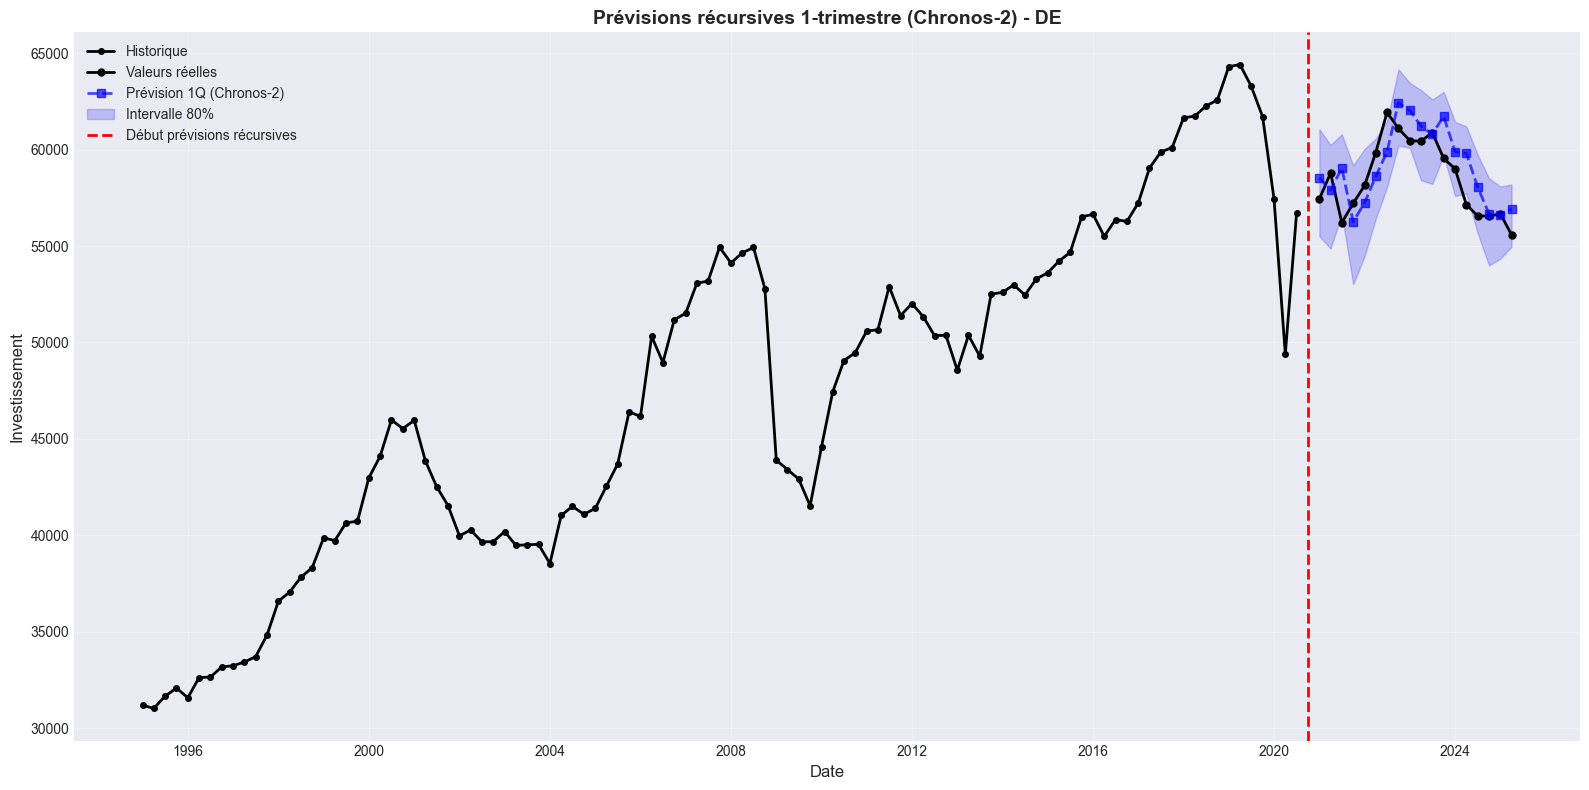

In [ ]:
### 1. Visualisation des prévisions par horizon pour Chronos-2

# Select only 1-quarter ahead forecasts (horizon_step == 1) for cleaner visualization
chronos_1q = recursive_chronos_forecasts[recursive_chronos_forecasts['horizon_step'] == 1].copy()

# Get the median column
median_col = [col for col in chronos_1q.columns if 'p50' in col.lower()][0]
p10_col = [col for col in chronos_1q.columns if 'p10' in col.lower()][0]
p90_col = [col for col in chronos_1q.columns if 'p90' in col.lower()][0]

# Get historical data for context
hist_data = df_full[df_full[ID_COLUMN] == RECURSIVE_COUNTRY].copy()
hist_data = hist_data[hist_data[TIMESTAMP_COLUMN] < pd.to_datetime(RECURSIVE_START_DATE)]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot historical data
ax.plot(hist_data[TIMESTAMP_COLUMN], hist_data[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=4, label='Historique', color='black')

# Plot actual values in forecast period
actual_mask = chronos_1q['actual'].notna()
if actual_mask.any():
    ax.plot(chronos_1q.loc[actual_mask, TIMESTAMP_COLUMN], 
           chronos_1q.loc[actual_mask, 'actual'], 
           'o-', linewidth=2, markersize=5, label='Valeurs réelles', 
           color='black')

# Plot 1-quarter ahead forecasts
ax.plot(chronos_1q[TIMESTAMP_COLUMN], chronos_1q[median_col], 
       's--', linewidth=2, markersize=6, label='Prévision 1Q (Chronos-2)', 
       color='blue', alpha=0.7)

# Add confidence intervals
ax.fill_between(chronos_1q[TIMESTAMP_COLUMN], 
                chronos_1q[p10_col], 
                chronos_1q[p90_col],
                alpha=0.2, color='blue', label='Intervalle 80%')

ax.axvline(x=pd.to_datetime(RECURSIVE_START_DATE), color='red', 
          linestyle='--', linewidth=2, label='Début prévisions récursives')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Prévisions récursives 1-trimestre (Chronos-2) - {RECURSIVE_COUNTRY}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


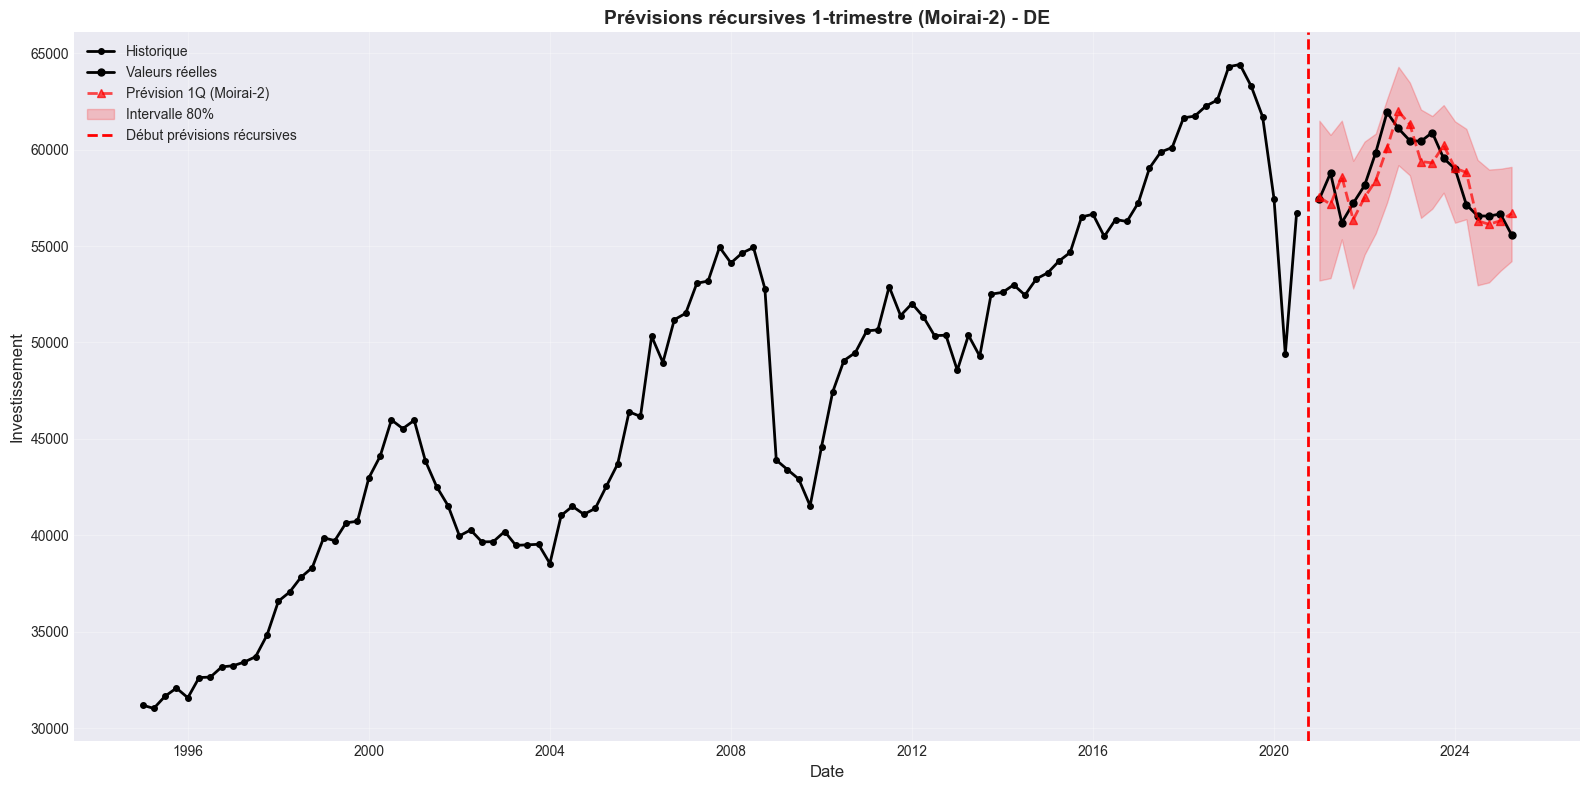

In [ ]:
### 1b. Visualisation des prévisions par horizon pour Moirai-2

# Select only 1-quarter ahead forecasts (horizon_step == 1) for cleaner visualization
moirai_1q = recursive_moirai_forecasts[recursive_moirai_forecasts['horizon_step'] == 1].copy()

# Get the median column
median_col_m = [col for col in moirai_1q.columns if 'p50' in col.lower()][0]
p10_col_m = [col for col in moirai_1q.columns if 'p10' in col.lower()][0]
p90_col_m = [col for col in moirai_1q.columns if 'p90' in col.lower()][0]

# Get historical data for context
hist_data_m = df_full[df_full[ID_COLUMN] == RECURSIVE_COUNTRY].copy()
hist_data_m = hist_data_m[hist_data_m[TIMESTAMP_COLUMN] < pd.to_datetime(RECURSIVE_START_DATE)]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot historical data
ax.plot(hist_data_m[TIMESTAMP_COLUMN], hist_data_m[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=4, label='Historique', color='black')

# Plot actual values in forecast period
actual_mask_m = moirai_1q['actual'].notna()
if actual_mask_m.any():
    ax.plot(moirai_1q.loc[actual_mask_m, TIMESTAMP_COLUMN], 
           moirai_1q.loc[actual_mask_m, 'actual'], 
           'o-', linewidth=2, markersize=5, label='Valeurs réelles', 
           color='black')

# Plot 1-quarter ahead forecasts
ax.plot(moirai_1q[TIMESTAMP_COLUMN], moirai_1q[median_col_m], 
       '^--', linewidth=2, markersize=6, label='Prévision 1Q (Moirai-2)', 
       color='red', alpha=0.7)

# Add confidence intervals
ax.fill_between(moirai_1q[TIMESTAMP_COLUMN], 
                moirai_1q[p10_col_m], 
                moirai_1q[p90_col_m],
                alpha=0.2, color='red', label='Intervalle 80%')

ax.axvline(x=pd.to_datetime(RECURSIVE_START_DATE), color='red', 
          linestyle='--', linewidth=2, label='Début prévisions récursives')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investissement', fontsize=12)
ax.set_title(f'Prévisions récursives 1-trimestre (Moirai-2) - {RECURSIVE_COUNTRY}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


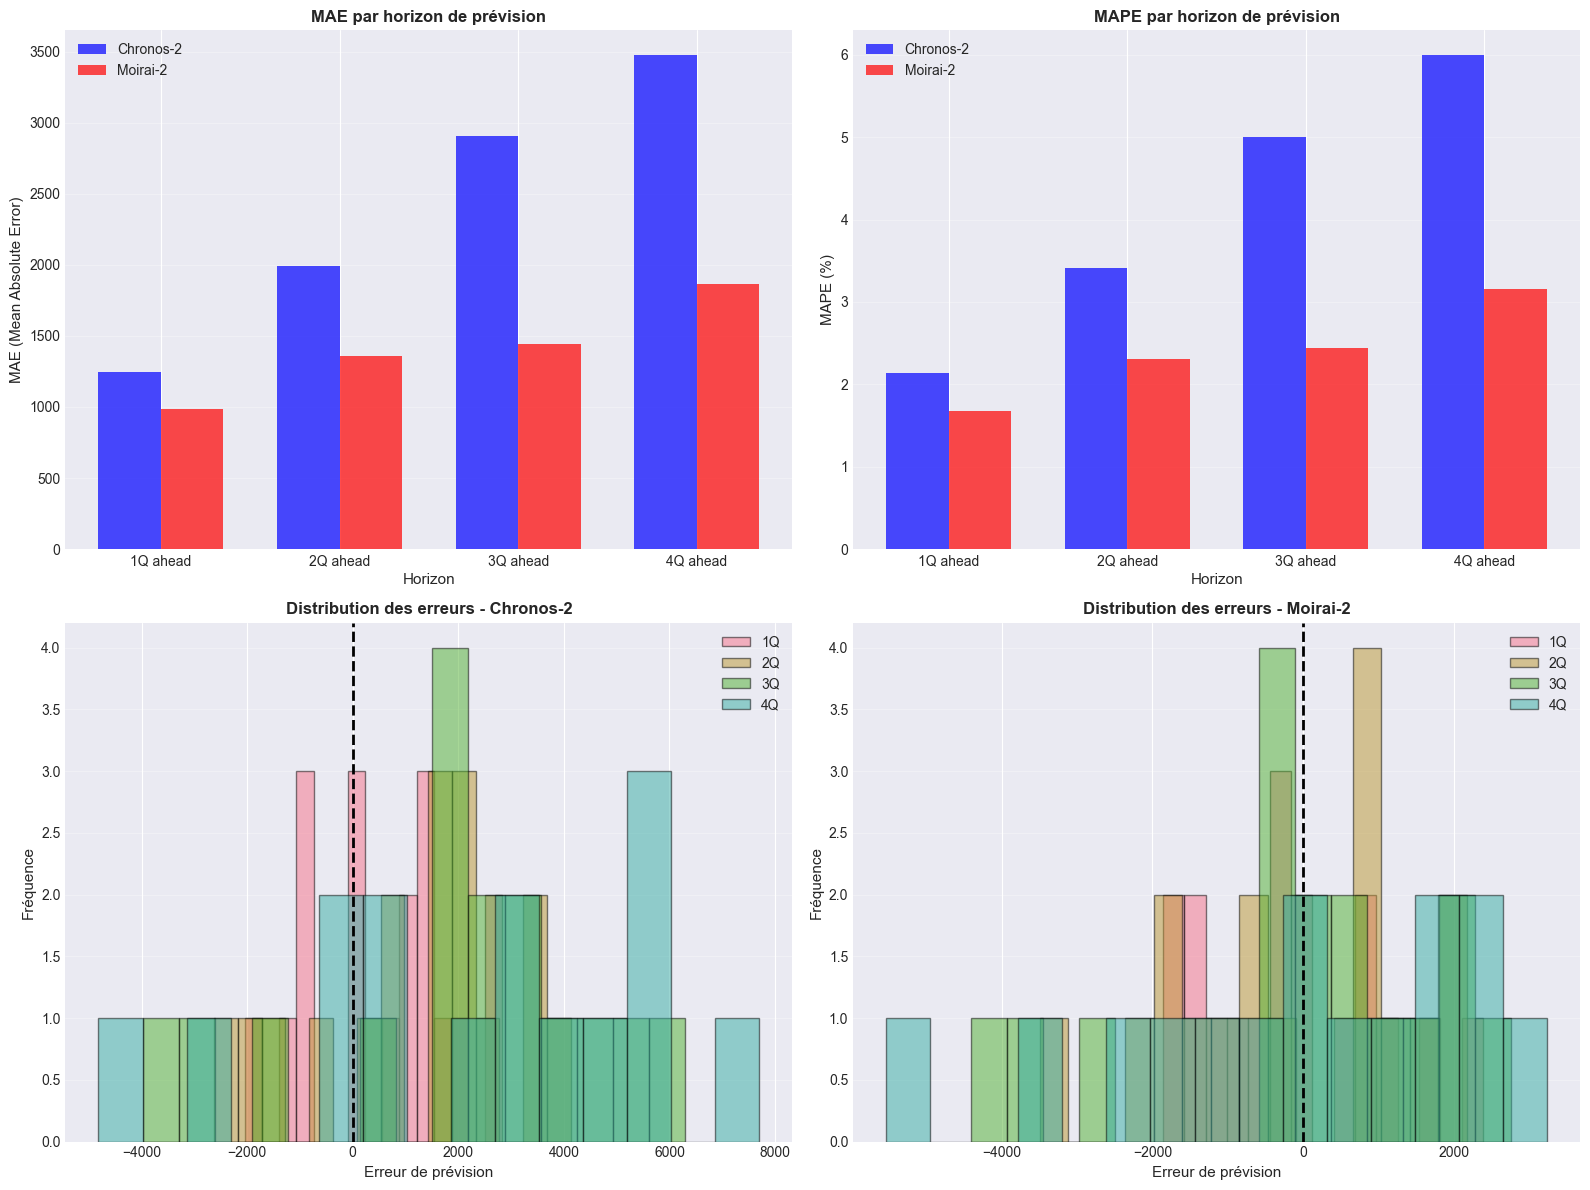

In [ ]:
### 2. Comparaison des erreurs par horizon

if chronos_with_errors is not None and moirai_with_errors is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Get median columns
    chronos_median = [col for col in chronos_with_errors.columns if 'chronos' in col.lower() and 'p50' in col.lower()][0]
    moirai_median = [col for col in moirai_with_errors.columns if 'moirai' in col.lower() and 'p50' in col.lower()][0]
    
    # 1. MAE by horizon
    ax = axes[0, 0]
    chronos_mae_by_h = chronos_by_horizon.set_index('Horizon')['MAE']
    moirai_mae_by_h = moirai_by_horizon.set_index('Horizon')['MAE']
    
    x = np.arange(len(chronos_mae_by_h))
    width = 0.35
    ax.bar(x - width/2, chronos_mae_by_h.values, width, label='Chronos-2', color='blue', alpha=0.7)
    ax.bar(x + width/2, moirai_mae_by_h.values, width, label='Moirai-2', color='red', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAE (Mean Absolute Error)', fontsize=11)
    ax.set_title('MAE par horizon de prévision', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(chronos_mae_by_h.index)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. MAPE by horizon
    ax = axes[0, 1]
    chronos_mape_by_h = chronos_by_horizon.set_index('Horizon')['MAPE']
    moirai_mape_by_h = moirai_by_horizon.set_index('Horizon')['MAPE']
    
    ax.bar(x - width/2, chronos_mape_by_h.values, width, label='Chronos-2', color='blue', alpha=0.7)
    ax.bar(x + width/2, moirai_mape_by_h.values, width, label='Moirai-2', color='red', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAPE (%)', fontsize=11)
    ax.set_title('MAPE par horizon de prévision', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(chronos_mape_by_h.index)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Error distribution for Chronos-2
    ax = axes[1, 0]
    for h in sorted(chronos_with_errors['horizon_step'].unique()):
        h_data = chronos_with_errors[chronos_with_errors['horizon_step'] == h]
        ax.hist(h_data['error'], bins=15, alpha=0.5, label=f'{h}Q', edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Erreur de prévision', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title('Distribution des erreurs - Chronos-2', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Error distribution for Moirai-2
    ax = axes[1, 1]
    for h in sorted(moirai_with_errors['horizon_step'].unique()):
        h_data = moirai_with_errors[moirai_with_errors['horizon_step'] == h]
        ax.hist(h_data['error'], bins=15, alpha=0.5, label=f'{h}Q', edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Erreur de prévision', fontsize=11)
    ax.set_ylabel('Fréquence', fontsize=11)
    ax.set_title('Distribution des erreurs - Moirai-2', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


---

## 📊 ÉVALUATION CLAIRE : Convergence des Prévisions Récursives

### 🎯 Objectif de cette analyse

Cette section évalue si **les prévisions deviennent plus précises lorsqu'on est plus proche de la date cible**.

### 🔍 Méthodologie

Pour chaque date future (ex: 2022-Q1), nous avons **plusieurs prévisions** faites à différents moments:

| Prévision faite le | Horizon | Date cible |
|-------------------|---------|------------|
| 2021-Q1 | 4 trimestres avant | 2022-Q1 |
| 2021-Q2 | 3 trimestres avant | 2022-Q1 |
| 2021-Q3 | 2 trimestres avant | 2022-Q1 |
| 2021-Q4 | 1 trimestre avant | 2022-Q1 |

**Question clé**: Est-ce que la prévision faite en 2021-Q4 (1 trimestre avant) est plus précise que celle faite en 2021-Q1 (4 trimestres avant)?

### 📈 Interprétation des métriques

Les visualisations suivantes montrent:

1. **Graphique de convergence** (Cell 3)
   - X-axis: Trimestres avant la date cible (4Q, 3Q, 2Q, 1Q)
   - Y-axis: Valeur prédite de l'investissement
   - Ligne horizontale noire: Valeur réelle
   - **Annotations**: Erreur absolue de chaque prévision
   - **Interprétation**: Les points devraient converger vers la ligne noire quand on se rapproche de la cible

2. **Tableau de convergence** (Cell 3b)
   - Montre MAE, RMSE, MAPE pour chaque horizon
   - **Interprétation**: Les valeurs devraient diminuer de 4Q vers 1Q
   - **Dégradation**: Ratio MAE(4Q)/MAE(1Q) - plus il est élevé, plus les prévisions à long terme sont difficiles

3. **Graphiques d'évolution** (Cell 3c)
   - Evolution MAE et MAPE par horizon
   - Variabilité (écart-type) des erreurs
   - **Interprétation**: Une courbe descendante de gauche à droite indique une convergence saine

### ✅ Ce qu'on cherche (bon signe)

- ✅ MAE diminue quand l'horizon diminue (de 4Q vers 1Q)
- ✅ Les prévisions convergent vers la valeur réelle dans le graphique
- ✅ Faible écart-type = prédictions consistantes
- ✅ MAPE < 5% = bonne précision

### ⚠️ Signaux d'alerte (mauvais signe)

- ❌ MAE n'améliore pas ou empire en s'approchant de la cible
- ❌ Prévisions divergent ou oscillent autour de la valeur réelle
- ❌ Écart-type élevé = prédictions erratiques
- ❌ MAPE > 10% = précision médiocre

---


In [ ]:
### 3b. Tableau de convergence des erreurs

# This table shows quantitatively how forecast errors change as we get closer to the target date
# It answers: "Does forecast accuracy improve when we have more recent data?"

def analyze_convergence(forecasts_df, model_name):
    """Analyze how errors change as horizon decreases (getting closer to target)."""
    # Filter to only forecasts with actual values
    with_actual = forecasts_df[forecasts_df['actual'].notna()].copy()
    
    if len(with_actual) == 0:
        return None
    
    # Get median column
    median_col = [col for col in with_actual.columns if 'p50' in col.lower()][0]
    
    # Calculate errors
    with_actual['abs_error'] = np.abs(with_actual[median_col] - with_actual['actual'])
    with_actual['pct_error'] = (with_actual['abs_error'] / with_actual['actual']) * 100
    
    # Group by horizon
    convergence = with_actual.groupby('horizon_step').agg({
        'abs_error': ['mean', 'std', 'min', 'max'],
        'pct_error': ['mean', 'std'],
        'timestamp': 'count'
    }).round(2)
    
    convergence.columns = ['MAE', 'Std Error', 'Min Error', 'Max Error', 'MAPE (%)', 'Std MAPE (%)', 'N']
    convergence.index.name = 'Horizon'
    
    return convergence

print("=" * 100)
print("📊 ANALYSE DE CONVERGENCE - Comment les erreurs évoluent selon l'horizon")
print("=" * 100)

# Chronos-2
chronos_convergence = analyze_convergence(recursive_chronos_forecasts, 'Chronos-2')
if chronos_convergence is not None:
    print(f"\n🔵 CHRONOS-2 - Erreurs par horizon de prévision:")
    print("   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)")
    print()
    print(chronos_convergence.to_string())
    
    # Calculate improvement from 4Q to 1Q ahead
    mae_4q = chronos_convergence.loc[4, 'MAE']
    mae_1q = chronos_convergence.loc[1, 'MAE']
    improvement = ((mae_4q - mae_1q) / mae_4q) * 100
    print(f"\n   💡 Amélioration de précision: {improvement:.1f}% entre 4Q et 1Q avant")
    print(f"      MAE passe de {mae_4q:.0f} (4Q) à {mae_1q:.0f} (1Q)")

# Moirai-2
moirai_convergence = analyze_convergence(recursive_moirai_forecasts, 'Moirai-2')
if moirai_convergence is not None:
    print(f"\n🔴 MOIRAI-2 - Erreurs par horizon de prévision:")
    print("   (Horizon 1 = 1 trimestre avant la date cible, Horizon 4 = 4 trimestres avant)")
    print()
    print(moirai_convergence.to_string())
    
    # Calculate improvement from 4Q to 1Q ahead
    mae_4q_m = moirai_convergence.loc[4, 'MAE']
    mae_1q_m = moirai_convergence.loc[1, 'MAE']
    improvement_m = ((mae_4q_m - mae_1q_m) / mae_4q_m) * 100
    print(f"\n   💡 Amélioration de précision: {improvement_m:.1f}% entre 4Q et 1Q avant")
    print(f"      MAE passe de {mae_4q_m:.0f} (4Q) à {mae_1q_m:.0f} (1Q)")

# Comparison
if chronos_convergence is not None and moirai_convergence is not None:
    print(f"\n📊 COMPARAISON:")
    print(f"\n   Prévisions à 1 trimestre (les plus récentes):")
    print(f"     Chronos-2: MAE = {chronos_convergence.loc[1, 'MAE']:.0f}, MAPE = {chronos_convergence.loc[1, 'MAPE (%)']:.2f}%")
    print(f"     Moirai-2:  MAE = {moirai_convergence.loc[1, 'MAE']:.0f}, MAPE = {moirai_convergence.loc[1, 'MAPE (%)']:.2f}%")
    
    print(f"\n   Prévisions à 4 trimestres (les plus éloignées):")
    print(f"     Chronos-2: MAE = {chronos_convergence.loc[4, 'MAE']:.0f}, MAPE = {chronos_convergence.loc[4, 'MAPE (%)']:.2f}%")
    print(f"     Moirai-2:  MAE = {moirai_convergence.loc[4, 'MAE']:.0f}, MAPE = {moirai_convergence.loc[4, 'MAPE (%)']:.2f}%")
    
    # Determine which model handles long-term better
    chronos_degradation = mae_4q / mae_1q
    moirai_degradation = mae_4q_m / mae_1q_m
    
    print(f"\n   Dégradation des prévisions à long terme:")
    print(f"     Chronos-2: MAE(4Q) / MAE(1Q) = {chronos_degradation:.2f}x")
    print(f"     Moirai-2:  MAE(4Q) / MAE(1Q) = {moirai_degradation:.2f}x")
    
    if moirai_degradation < chronos_degradation:
        print(f"\n   ✅ Moirai-2 maintient mieux sa précision sur des horizons longs")
    else:
        print(f"\n   ✅ Chronos-2 maintient mieux sa précision sur des horizons longs")

print("\n" + "=" * 100)


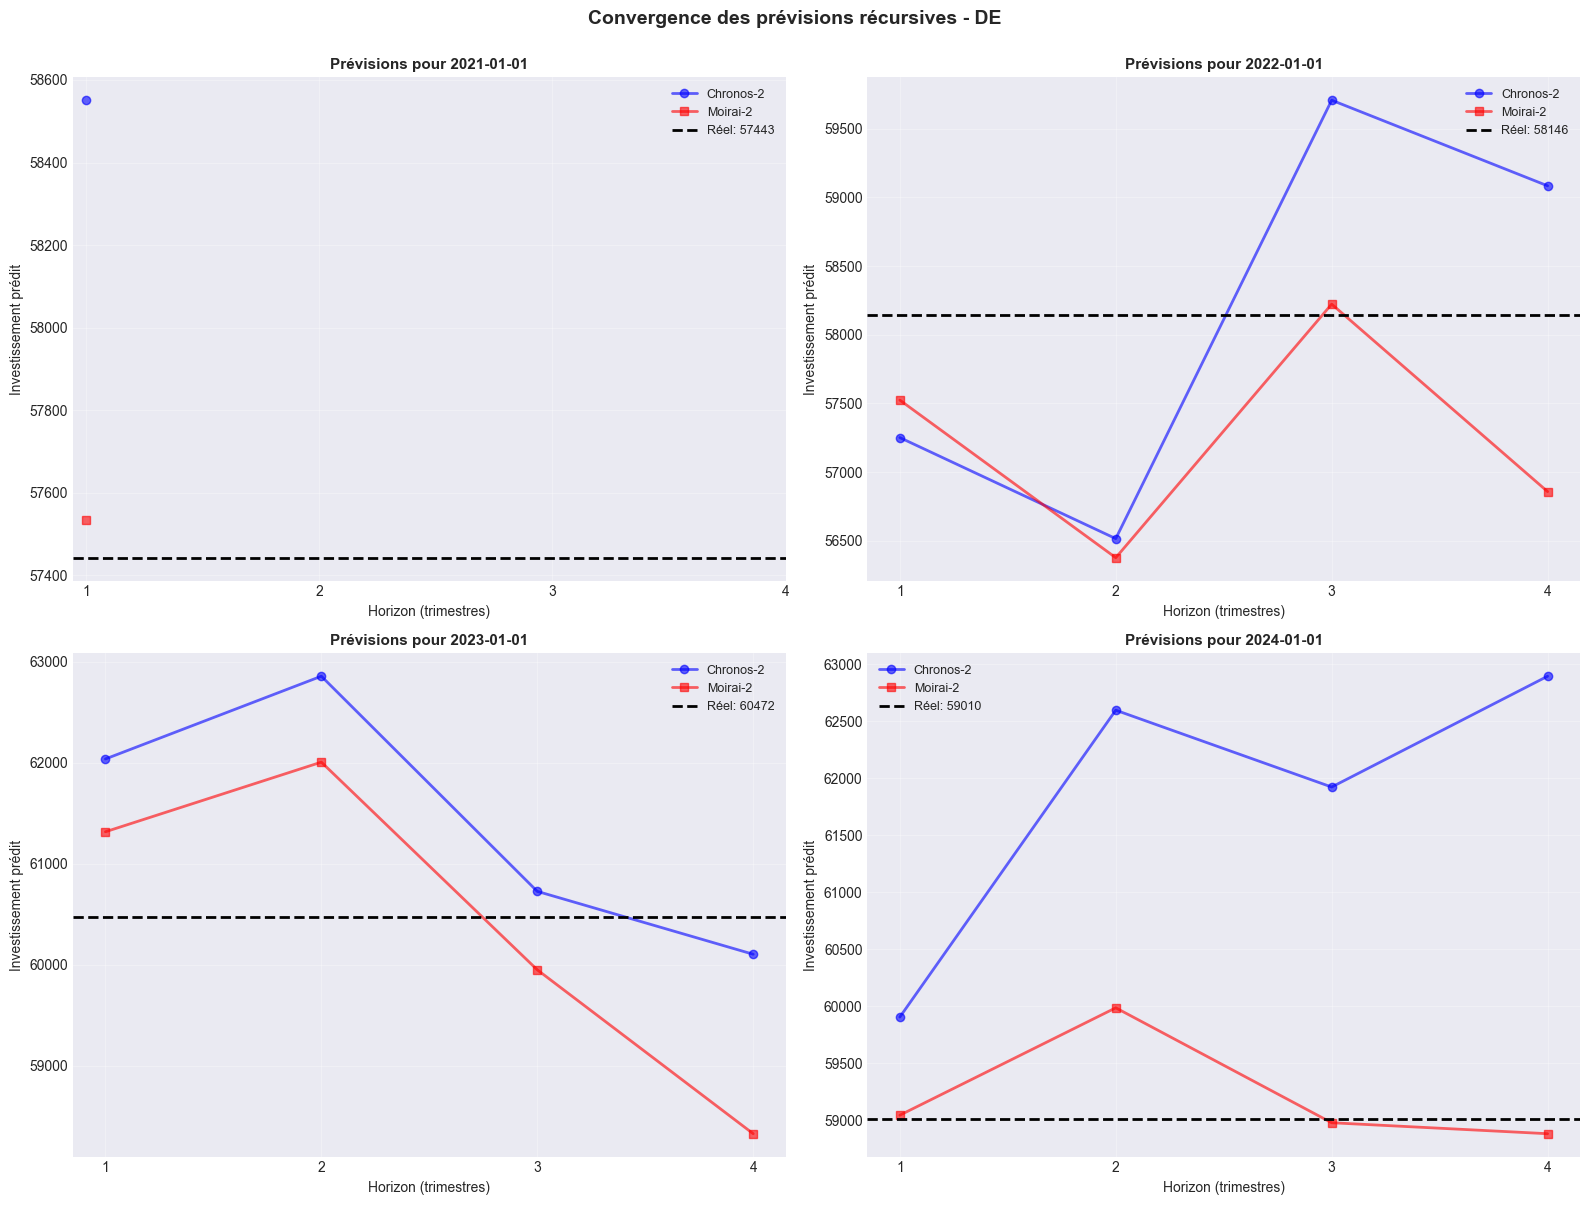

In [ ]:
### 3. Visualisation des trajectoires de prévision convergentes

# This visualization shows how forecasts from different origins converge on the same target date
# For example, we can see multiple forecasts for 2022-Q1, made from different origin dates

def plot_forecast_paths(forecasts_df, target_date, model_name='Model', color='blue'):
    """Plot all forecast paths that predict a specific target date."""
    target_ts = pd.to_datetime(target_date)
    
    # Find all forecasts for this target date
    paths = forecasts_df[forecasts_df[TIMESTAMP_COLUMN] == target_ts].copy()
    
    if len(paths) == 0:
        print(f"No forecasts found for {target_date}")
        return None
    
    # Get actual value
    actual_val = paths['actual'].iloc[0] if paths['actual'].notna().any() else None
    
    # Get median column
    median_col = [col for col in paths.columns if 'p50' in col.lower()][0]
    
    return paths, actual_val, median_col

# Select a few target dates to visualize
target_dates = pd.date_range(start='2021-01-01', end='2024-01-01', freq='YS')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, target_date in enumerate(target_dates[:4]):
    ax = axes[idx]
    
    # Chronos paths
    chronos_paths, actual_chronos, chronos_med = plot_forecast_paths(
        recursive_chronos_forecasts, target_date, 'Chronos-2', 'blue'
    )
    
    # Moirai paths
    moirai_paths, actual_moirai, moirai_med = plot_forecast_paths(
        recursive_moirai_forecasts, target_date, 'Moirai-2', 'red'
    )
    
    if chronos_paths is not None:
        # Plot Chronos forecasts from different origins
        origins = chronos_paths['origin_date'].values
        forecasts = chronos_paths[chronos_med].values
        horizons = chronos_paths['horizon_step'].values
        
        ax.plot(horizons, forecasts, 'o-', color='blue', alpha=0.6, 
               linewidth=2, markersize=6, label='Chronos-2')
        
    if moirai_paths is not None:
        # Plot Moirai forecasts from different origins
        origins_m = moirai_paths['origin_date'].values
        forecasts_m = moirai_paths[moirai_med].values
        horizons_m = moirai_paths['horizon_step'].values
        
        ax.plot(horizons_m, forecasts_m, 's-', color='red', alpha=0.6, 
               linewidth=2, markersize=6, label='Moirai-2')
    
    # Plot actual value
    if actual_chronos is not None:
        ax.axhline(y=actual_chronos, color='black', linestyle='--', 
                  linewidth=2, label=f'Réel: {actual_chronos:.0f}')
    
    ax.set_xlabel('Horizon (trimestres)', fontsize=10)
    ax.set_ylabel('Investissement prédit', fontsize=10)
    ax.set_title(f'Prévisions pour {target_date.strftime("%Y-%m-%d")}', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([1, 2, 3, 4])

plt.suptitle(f'Convergence des prévisions récursives - {RECURSIVE_COUNTRY}', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [ ]:
## Export des prévisions récursives

# Create output directory
output_dir = project_root / "results" / "recursive"
output_dir.mkdir(parents=True, exist_ok=True)

# Save Chronos-2 recursive forecasts
chronos_output = output_dir / f"recursive_chronos_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
recursive_chronos_forecasts.to_csv(chronos_output, index=False)

# Save Moirai-2 recursive forecasts
moirai_output = output_dir / f"recursive_moirai_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
recursive_moirai_forecasts.to_csv(moirai_output, index=False)

# Save metrics
if chronos_by_horizon is not None and moirai_by_horizon is not None:
    metrics_output = output_dir / f"recursive_metrics_{RECURSIVE_COUNTRY}_{RECURSIVE_HORIZON}q.csv"
    
    # Combine metrics
    chronos_by_horizon['Model'] = 'Chronos-2'
    moirai_by_horizon['Model'] = 'Moirai-2'
    combined_metrics = pd.concat([chronos_by_horizon, moirai_by_horizon], ignore_index=True)
    combined_metrics.to_csv(metrics_output, index=False)
    
    print(f"✅ Métriques sauvegardées: {metrics_output}")

print(f"✅ Prévisions récursives sauvegardées:")
print(f"  Chronos-2: {chronos_output}")
print(f"  Moirai-2: {moirai_output}")


✅ Métriques sauvegardées: results/recursive/recursive_metrics_DE_4q.csv
✅ Prévisions récursives sauvegardées:
  Chronos-2: results/recursive/recursive_chronos_DE_4q.csv
  Moirai-2: results/recursive/recursive_moirai_DE_4q.csv


In [ ]:
## Résumé des prévisions récursives

print("=" * 80)
print("📊 RÉSUMÉ - PRÉVISIONS RÉCURSIVES")
print("=" * 80)

print(f"\n🎯 Configuration:")
print(f"  Pays: {RECURSIVE_COUNTRY}")
print(f"  Période: {RECURSIVE_START_DATE} → {RECURSIVE_END_DATE}")
print(f"  Horizon par prévision: {RECURSIVE_HORIZON} trimestres")
print(f"  Quantiles: {QUANTILE_LEVELS}")

print(f"\n📈 Nombre total de prévisions générées:")
print(f"  Chronos-2: {len(recursive_chronos_forecasts)} prévisions")
print(f"  Moirai-2: {len(recursive_moirai_forecasts)} prévisions")

if chronos_overall and moirai_overall:
    print(f"\n🎯 Performance globale:")
    print(f"\n  Chronos-2:")
    print(f"    MAE:  {chronos_overall['MAE']:.2f}")
    print(f"    RMSE: {chronos_overall['RMSE']:.2f}")
    print(f"    MAPE: {chronos_overall['MAPE']:.2f}%")
    
    print(f"\n  Moirai-2:")
    print(f"    MAE:  {moirai_overall['MAE']:.2f}")
    print(f"    RMSE: {moirai_overall['RMSE']:.2f}")
    print(f"    MAPE: {moirai_overall['MAPE']:.2f}%")
    
    print(f"\n  🏆 Meilleur modèle:")
    if chronos_overall['MAE'] < moirai_overall['MAE']:
        improvement = ((moirai_overall['MAE'] - chronos_overall['MAE']) / moirai_overall['MAE']) * 100
        print(f"    Chronos-2 (MAE {improvement:.1f}% inférieure)")
    else:
        improvement = ((chronos_overall['MAE'] - moirai_overall['MAE']) / chronos_overall['MAE']) * 100
        print(f"    Moirai-2 (MAE {improvement:.1f}% inférieure)")

print(f"\n💾 Fichiers sauvegardés:")
print(f"  {output_dir}/")

print("\n✅ Analyse récursive terminée!")
print("=" * 80)


📊 RÉSUMÉ - PRÉVISIONS RÉCURSIVES

🎯 Configuration:
  Pays: DE
  Période: 2020-10-01 → 2025-01-01
  Horizon par prévision: 4 trimestres
  Quantiles: [0.1, 0.5, 0.9]

📈 Nombre total de prévisions générées:
  Chronos-2: 72 prévisions
  Moirai-2: 72 prévisions

🎯 Performance globale:

  Chronos-2:
    MAE:  2349.07
    RMSE: 2884.66
    MAPE: 4.04%

  Moirai-2:
    MAE:  1393.21
    RMSE: 1775.57
    MAPE: 2.36%

  🏆 Meilleur modèle:
    Moirai-2 (MAE 40.7% inférieure)

💾 Fichiers sauvegardés:
  results/recursive/

✅ Analyse récursive terminée!


---

## 📝 Notes sur la méthodologie récursive

### Principe de la prévision récursive

La **prévision récursive** (ou rolling forecast) fonctionne différemment de la prévision directe:

#### Approche directe (sections précédentes):
- Utiliser les données jusqu'à une date fixe (ex: 2020-Q4)
- Prévoir tous les futurs trimestres en une seule fois (ex: 17 trimestres)
- Génère une seule prévision par date future

#### Approche récursive (cette section):
- Pour **chaque trimestre** de la période de test:
  1. Utiliser toutes les données disponibles jusqu'à ce trimestre
  2. Prévoir les N prochains trimestres (ex: 4 trimestres)
  3. Stocker les prévisions
- Génère **plusieurs prévisions** par date future (à différents horizons)

### Exemple concret

Pour prévoir 2022-Q1 avec un horizon de 4 trimestres:

| Origine | Données jusqu'à | Horizon | Prévision pour 2022-Q1 |
|---------|----------------|---------|------------------------|
| 2020-Q4 | 2020-Q4 | 4Q | Prévision 1 |
| 2021-Q1 | 2021-Q1 | 3Q | Prévision 2 |
| 2021-Q2 | 2021-Q2 | 2Q | Prévision 3 |
| 2021-Q3 | 2021-Q3 | 1Q | Prévision 4 |

Résultat: 4 prévisions différentes pour 2022-Q1, chacune avec un horizon différent.

### Avantages de cette approche

1. **Évaluation plus réaliste**: Simule comment le modèle serait utilisé en production
2. **Analyse par horizon**: Permet de voir si les prévisions à court terme sont plus précises
3. **Robustesse**: Teste le modèle avec différentes quantités de données historiques
4. **Détection de tendances**: Montre comment les prévisions évoluent au fil du temps

### Métriques calculées

- **Par horizon**: MAE, RMSE, MAPE pour 1Q, 2Q, 3Q, 4Q
- **Globales**: Moyennes sur tous les horizons et toutes les dates
- **Distribution des erreurs**: Analyse de la cohérence des prévisions
